**DRIVER DROWSINESS DETECTION SYSTEM**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset_Final.zip') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

**GENERATING TEST-TRAIN-VAL DATA**

In [7]:
from keras.utils import image_dataset_from_directory

import tensorflow as tf

tf.config.run_functions_eagerly(True)

In [8]:
# 1st way 
train_dataset_vgg16 = image_dataset_from_directory('/tmp/Dataset_Final/train',batch_size=32,image_size=(224, 224),label_mode='categorical')
test_dataset_vgg16 = image_dataset_from_directory('/tmp/Dataset_Final/test',batch_size=32,image_size=(224,224),label_mode='categorical')
val_dataset_vgg16 = image_dataset_from_directory('/tmp/Dataset_Final/val',batch_size=32,image_size=(224,224),label_mode='categorical')

Found 67917 files belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Found 8492 files belonging to 2 classes.
Found 8489 files belonging to 2 classes.


In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)


In [10]:
# 2nd way
train_data= train_datagen.flow_from_directory(r'/tmp/Dataset_Final/train',target_size=(224,224),batch_size=8,class_mode='categorical',subset='training')
validation_data= train_datagen.flow_from_directory(r'/tmp/Dataset_Final/test',target_size=(224,224),batch_size=8,class_mode='categorical', subset='validation')


Found 54334 images belonging to 2 classes.
Found 1698 images belonging to 2 classes.


**ResNET**

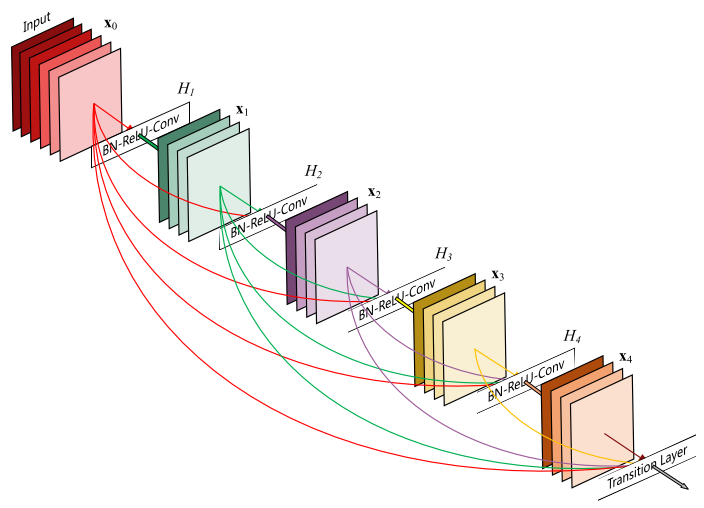

In [11]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [14]:
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(r'content/model_resnet.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

In [16]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_dataset_vgg16,validation_data=val_dataset_vgg16, epochs=10,callbacks=callbacks)

Epoch 1/10
2123/2123 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.9644
Epoch 1: val_loss improved from inf to 0.06745, saving model to content/model_resnet.h5
2123/2123 [==============================] - 766s 356ms/step - loss: 0.1004 - accuracy: 0.9644 - val_loss: 0.0675 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 2/10
2123/2123 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9765
Epoch 2: val_loss improved from 0.06745 to 0.05834, saving model to content/model_resnet.h5
2123/2123 [==============================] - 761s 358ms/step - loss: 0.0626 - accuracy: 0.9765 - val_loss: 0.0583 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 3/10
2123/2123 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9804
Epoch 3: val_loss improved from 0.05834 to 0.05592, saving model to content/model_resnet.h5
2123/2123 [==============================] - 753s 355ms/step - loss: 0.0520 - accuracy: 0.9804 - val_loss: 0.0559 - val_accuracy: 0.98

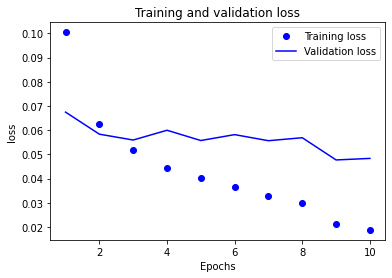

In [17]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

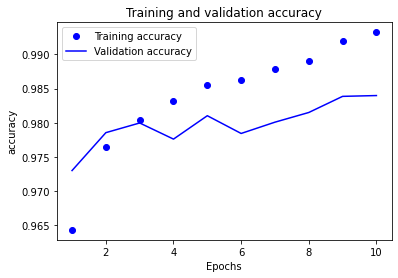

In [18]:
loss_values = history.history['accuracy']
val_loss_values = history.history['val_accuracy']

epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_loss_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()